In [32]:
import os
os.environ['JAX_ENABLE_X64'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.2' 

%matplotlib widget
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpy as np

from __future__ import annotations
import numpy as np
from skimage.restoration import unwrap_phase
from temgym_core.gaussian import map_reduce
from temgym_core.components import Detector

import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)
import jax_dataclasses as jdc

In [33]:
def _maybe_len(x):
    return x.shape[0] if (hasattr(x, "shape") and x.ndim > 0) else None

def _infer_batch_size(*xs):
    sizes = [n for n in map(_maybe_len, xs) if n is not None]
    return max(sizes) if sizes else 1

def _broadcast_to(x, shape):
    x = jnp.asarray(x)
    if x.shape == shape:
        return x
    return jnp.broadcast_to(x, shape)

def _ensure_batched_packet_arrays(gp):
    """
    Normalize a GaussianPacket (scalar or batched) into arrays with leading batch dim B.
    Returns dict:
      C   : (B,) complex
      k   : (B,) float
      path: (B,) float
      r_m : (B,2) float
      d_m : (B,2) float
      th  : (B,2) complex
      Q   : (B,2,2) complex
    """
    # Extract (may be scalar or batched)
    x  = jnp.asarray(gp.ray.x)
    y  = jnp.asarray(gp.ray.y)
    dx = jnp.asarray(gp.ray.dx)
    dy = jnp.asarray(gp.ray.dy)
    path = jnp.asarray(gp.ray.pathlength)

    th = jnp.asarray(gp.theta)      # (2,) or (B,2), complex
    Q  = jnp.asarray(gp.Q_inv)      # (2,2) or (B,2,2), complex
    C  = jnp.asarray(gp.C)          # () or (B,), complex
    k0 = jnp.asarray(gp.k0)         # () or (B,), float

    B = _infer_batch_size(x, y, dx, dy, path, th, Q, C, k0)

    C   = _broadcast_to(C,   (B,)).astype(jnp.complex128)
    k0  = _broadcast_to(k0,  (B,)).astype(jnp.float64)
    path= _broadcast_to(path,(B,)).astype(jnp.float64)
    r_m = jnp.stack([_broadcast_to(x,(B,)), _broadcast_to(y,(B,))], axis=-1).astype(jnp.float64)
    d_m = jnp.stack([_broadcast_to(dx,(B,)),_broadcast_to(dy,(B,))], axis=-1).astype(jnp.float64)
    th  = _broadcast_to(th,  (B,2)).astype(jnp.complex128)
    Q   = _broadcast_to(Q,   (B,2,2)).astype(jnp.complex128)

    return dict(C=C, k=k0, path=path, r_m=r_m, d_m=d_m, th=th, Q=Q)


def _packet_field(a_i, p_i, Q_i, r_m_i, ttot_i, k_i, r2):
    """
    One packet's contribution on all pixels r2: returns (P,) complex.
    """
    # r2: (P,2), r_m_i:(2,), Q_i:(2,2), ttot_i:(2,) complex
    delta = r2 - r_m_i[None, :]                       # (P,2)
    Qsym  = 0.5 * (Q_i + Q_i.T)                  # (2,2)
    quad  = jnp.einsum("pi,ij,pj->p", delta, Qsym, delta)         # (P,)
    lin   = 2.0 * jnp.einsum("pi,i->p", delta, ttot_i)           # (P,) complex
    phase = 0.5 * k_i * (quad + lin)                              # (P,) complex (via lin)
    return a_i * jnp.exp(1j * p_i) * jnp.exp(-1j * phase)          # (P,)

def _packet_field_outer(xs, r2):
    a_i, p_i, Q_i, r_m_i, ttot_i, k_i = xs
    return _packet_field(a_i, p_i, Q_i, r_m_i, ttot_i, k_i, r2)

def evaluate_gaussian_packets_jax_scan(gp, grid, *, batch_size: int | None = 128):
    arrs = _ensure_batched_packet_arrays(gp)
    C, k, path, r_m, d_m, th, Q = arrs["C"], arrs["k"], arrs["path"], arrs["r_m"], arrs["d_m"], arrs["th"], arrs["Q"]

    # DO NOT add d_m if you enforce [dx,dy] = -Re(theta).
    theta_total = th                          # <- was th + d_m
    phase_offset = k * path

    r2 = grid.coords
    P  = r2.shape[0]
    init = jnp.zeros((P,), dtype=jnp.complex128)

    def f_pack(xs): return _packet_field_outer(xs, r2)
    xs = (C, phase_offset, Q, r_m, theta_total, k)
    out = map_reduce(f_pack, jnp.add, init, xs, batch_size=batch_size)
    return out.reshape(grid.shape)

evaluate_gaussian_packets_jax_scan = jax.jit(
    evaluate_gaussian_packets_jax_scan, static_argnames=["batch_size", "grid"]
)

In [34]:
@jdc.pytree_dataclass
class Ray:
    x: float; y: float; dx: float; dy: float; z: float
    pathlength: float = 0.0
    _one: float = 1.0
    def derive(self, **kw): return jdc.replace(self, **kw)
    def r_xy(self): return jnp.array([self.x, self.y])
    def d_xy(self): return jnp.array([self.dx, self.dy])

@jdc.pytree_dataclass
class GaussianPacket:
    ray: Ray
    theta: jnp.ndarray         # (2,) complex
    Q_inv: jnp.ndarray         # (2,2) complex
    C: complex
    k0: float
    def derive(self, **kw): return jdc.replace(self, **kw)

def apply_thin_element_local(
    gp: GaussianPacket,
    phi0: float, g_phi: jnp.ndarray, H_phi: jnp.ndarray,
    ell0: float = 0.0, g_ell: jnp.ndarray = None, H_ell: jnp.ndarray = None
) -> GaussianPacket:
    """C' = C e^{ell0} e^{i k phi0}; theta' = theta - g_phi + i/k g_ell; Qinv' = Qinv - H_phi + i/k H_ell
       Also update geometric direction with +g_phi (phase kick)."""
    k = gp.k0
    if g_ell is None: g_ell = jnp.zeros((2,))
    if H_ell is None: H_ell = jnp.zeros((2,2))
    # Symmetrize for numerical cleanliness
    H_phi = 0.5*(H_phi + H_phi.T)
    H_ell = 0.5*(H_ell + H_ell.T)

    C_out     = gp.C * jnp.exp(ell0) * jnp.exp(1j*k*phi0)
    theta_out = gp.theta - g_phi + (1j/k)*g_ell
    Qinv_out  = gp.Q_inv - H_phi + (1j/k)*H_ell

    dxy = gp.ray.d_xy() + g_phi
    ray_out = gp.ray.derive(dx=float(dxy[0]), dy=float(dxy[1]))
    return gp.derive(ray=ray_out, theta=theta_out, Q_inv=Qinv_out, C=C_out)

# ---------- Base class: thin phase element (override only OPL) ----------

@jdc.pytree_dataclass
class Component:
    z: float

    def opl(self, r_xy: jnp.ndarray) -> float:
        raise NotImplementedError

    def grad_hess_opl(self, r_xy: jnp.ndarray):
        phi = lambda rr: self.opl(rr)
        g = jax.grad(phi)(r_xy)         # (2,)
        H = jax.hessian(phi)(r_xy)      # (2,2)
        return g, H

    # --- Geometric ray kick (phase gradient) ---
    def __call__(self, ray: Ray) -> Ray:
        r = ray.r_xy()
        g_phi, _ = self.grad_hess_opl(r)
        return ray.derive(dx=float(ray.dx + g_phi[0]),
                          dy=float(ray.dy + g_phi[1]),
                          z=self.z)

    # --- Gaussian packet update (phase-only) ---
    def gaussian_update(self, gp: GaussianPacket) -> GaussianPacket:
        r = gp.ray.r_xy()
        g_phi, H_phi = self.grad_hess_opl(r)
        phi0 = self.opl(r)
        return apply_thin_element_local(
            gp,
            phi0=phi0, g_phi=g_phi, H_phi=H_phi,
            ell0=0.0, g_ell=jnp.zeros(2), H_ell=jnp.zeros((2,2))
        )

# ---------- Subclasses: only the OPL differs ----------

@jdc.pytree_dataclass
class Lens(Component):
    focal_length: float

    def opl(self, r_xy: jnp.ndarray) -> float:
        x, y = r_xy[0], r_xy[1]
        return -0.5 * (x*x + y*y) / self.focal_length


@jdc.pytree_dataclass
class AberratedLens(Component):
    focal_length: float
    C_sph: float = 0.0        # spherical aberration coefficient
    C_coma_x: float = 0.0     # coma along x
    C_coma_y: float = 0.0     # coma along y

    def opl(self, r_xy: jnp.ndarray) -> float:
        x, y = r_xy[0], r_xy[1]
        rho2 = x*x + y*y
        phi_lens = -0.5 * rho2 / self.focal_length
        phi_sph  = self.C_sph * (rho2 * rho2)                  # (x^2+y^2)^2
        phi_coma = self.C_coma_x * (x**3 + x*y**2) \
                 + self.C_coma_y * (y**3 + y*x**2)             # Seidel coma (Cartesian)
        return phi_lens + phi_sph + phi_coma


In [ ]:
lam = 0.25
k0  = 2*np.pi/lam
w0  = 4
x0, y0 = 5., 5.
f   = 100.0
C_sph   = 1.0e-6
C_coma_x = 1e-5
C_coma_y = 2e-4

ray0 = Ray(x=x0, y=y0, dx=0.0, dy=0.0, z=0.0)
Qinv0 = -1j * (2.0/(k0*w0**2)) * np.eye(2)
theta0 = jnp.array([0.0+0.0j, 0.0+0.0j])
C0 = 1.0 + 0.0j
gp0 = GaussianPacket(ray=ray0, theta=theta0, Q_inv=Qinv0, C=C0, k0=k0)

# -------------------- Apply the component to update the Gaussian --------------------
lens = AberratedLens(z=0.0, focal_length=f, C_sph=C_sph, C_coma_x=C_coma_x, C_coma_y=C_coma_y)
gp1  = lens.gaussian_update(gp0)   # <-- uses the component path

# -------------------- Evaluate fields on a grid --------------------

W = 60
Nx = Ny = 500
dx = W/Nx
dy = W/Ny
grid = Detector(z=lens.z + 0.0, pixel_size=(dx, dy), shape=(Nx, Ny))
coords = grid.coords
X, Y = coords[:,0].reshape(grid.shape), coords[:,1].reshape(grid.shape)
x, y = X[0,:], Y[:,0]

# Exact field (analytic phase OPL from the component) times input Gaussian envelope
phi_exact = lens.opl(np.stack([X, Y], axis=0))  # vectorized by numpy broadcasting
E_in = np.exp(-((X - x0)**2 + (Y - y0)**2)/w0**2)
E_exact = np.exp(1j*gp1.k0*phi_exact) * E_in

# Local-Gaussian approximation after the component update
# Evaluate at (X-x0, Y-y0) so the Gaussian is centered at (x0, y0)
# lin = gp1.theta[0]*(X - x0) + gp1.theta[1]*(Y - y0)
# Q = gp1.Q_inv
# quad = (Q[0,0]*((X - x0)**2) + (Q[0,1]+Q[1,0])*(0.5*(X - x0)*(Y - y0)) + Q[1,1]*((Y - y0)**2))
# E_local = gp1.C * np.exp(-1j*gp1.k0*(lin + 0.5*quad))

E_local = evaluate_gaussian_packets_jax_scan(gp1, grid, batch_size=1)

In [36]:

amp_exact = np.abs(E_exact); amp_exact /= amp_exact.max()

phase_exact = np.angle(E_exact)
phase_local = np.angle(E_local)
phase_diff = np.angle(np.exp(1j*(np.abs(phase_exact) - np.abs(phase_local))))
phase_exact_unwrapped = unwrap_phase(phase_exact)
phase_local_unwrapped = unwrap_phase(phase_local)

# Convert unwrapped phases to optical path length (OPL)
opl_exact_unwrapped = phase_exact_unwrapped / gp1.k0
opl_local_unwrapped = phase_local_unwrapped / gp1.k0

# Pick a reference point near the beam center (x0,y0) and align both OPLs there.
# This removes the arbitrary constant offset between the two OPL maps.
ix0 = np.argmin(np.abs(x - x0))
iy0 = np.argmin(np.abs(y - y0))

ref_exact = opl_exact_unwrapped[iy0, ix0]
ref_local = opl_local_unwrapped[iy0, ix0]

opl_exact_unwrapped = opl_exact_unwrapped - ref_exact
opl_local_unwrapped = opl_local_unwrapped - ref_local

# Keep wrapped/unwrapped phase variables consistent (if needed downstream)
phase_exact_unwrapped = opl_exact_unwrapped * gp1.k0
phase_local_unwrapped  = opl_local_unwrapped * gp1.k0

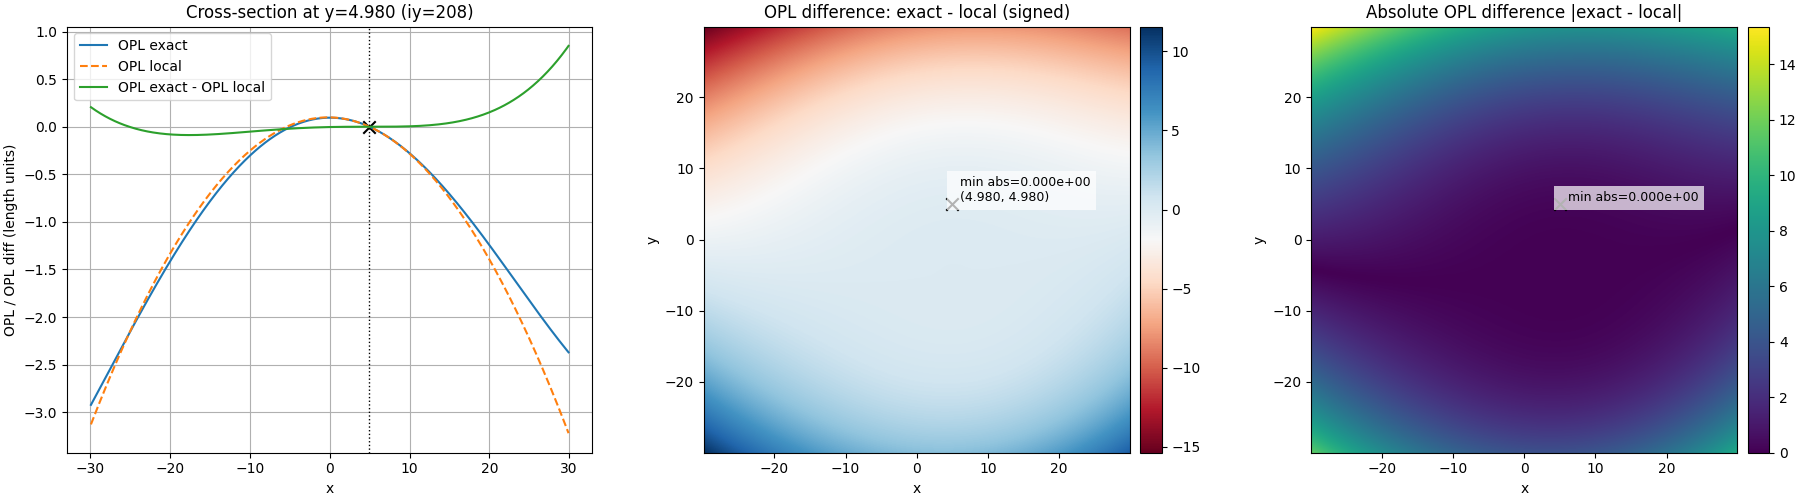

In [37]:
extent = [x.min(), x.max(), y.min(), y.max()]

# compute difference and global minimum (use existing variables if present)
diff_opl = opl_exact_unwrapped - opl_local_unwrapped
diff_abs = np.abs(diff_opl)
iy_min, ix_min = np.unravel_index(np.argmin(diff_abs), diff_abs.shape)
x_min = float(x[ix_min]); y_min = float(y[iy_min])
min_val = float(diff_abs[iy_min, ix_min])

iy = int(np.argmin(np.abs(y - y0)))  # cross-section row near y0
opl_diff_cross = diff_opl[iy, :]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

# 1) Cross-section at y ~ y0 (moved into first panel)
ax = axes[0]
ax.plot(x, opl_exact_unwrapped[iy, :], label='OPL exact', color='C0')
ax.plot(x, opl_local_unwrapped[iy, :], label='OPL local', linestyle='--', color='C1')
ax.plot(x, opl_diff_cross, label='OPL exact - OPL local', color='C2')
# mark global-min (vertical line + marker at cross-section value)
ax.axvline(x=x_min, color='k', linestyle=':', linewidth=1)
val_at_xmin = float(np.interp(x_min, x, opl_diff_cross))
ax.scatter([x_min], [val_at_xmin], c='k', marker='x', s=80)
ax.set_title(f'Cross-section at y={y[iy]:.3f} (iy={iy})')
ax.set_xlabel('x'); ax.set_ylabel('OPL / OPL diff (length units)')
ax.grid(True)
ax.legend(loc='upper left')

# 2) Signed OPL difference (exact - local)
ax = axes[1]
cmap = 'RdBu'
im2 = ax.imshow(diff_opl, origin='lower', extent=extent, aspect='equal', cmap=cmap)
ax.set_title('OPL difference: exact - local (signed)')
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.scatter(x_min, y_min, c='k', marker='x', s=80)
ax.text(x_min, y_min, f'  min abs={min_val:.3e}\n  ({x_min:.3f}, {y_min:.3f})',
    color='k', fontsize=9, verticalalignment='bottom', horizontalalignment='left',
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
fig.colorbar(im2, ax=ax, fraction=0.046, pad=0.02)

# 3) Absolute OPL difference (magnitude) for clarity
ax = axes[2]
im3 = ax.imshow(diff_abs, origin='lower', extent=extent, aspect='equal', cmap='viridis')
ax.set_title('Absolute OPL difference |exact - local|')
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.scatter(x_min, y_min, c='k', marker='x', s=80)
ax.text(x_min, y_min, f'  min abs={min_val:.3e}', color='k', fontsize=9,
    verticalalignment='bottom', horizontalalignment='left',
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
fig.colorbar(im3, ax=ax, fraction=0.046, pad=0.02)

plt.show()
